# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

Import required stuff.

In [2]:
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance
)
from desc.plotting import plot_comparison
from desc.optimize import Optimizer
from desc.perturbations import perturb,optimal_perturb
import numpy as np
from desc.geometry import PoincareSurface
%matplotlib inline
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints

DESC version 0.10.3+384.g907bb32d.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 10.99 GB available memory


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

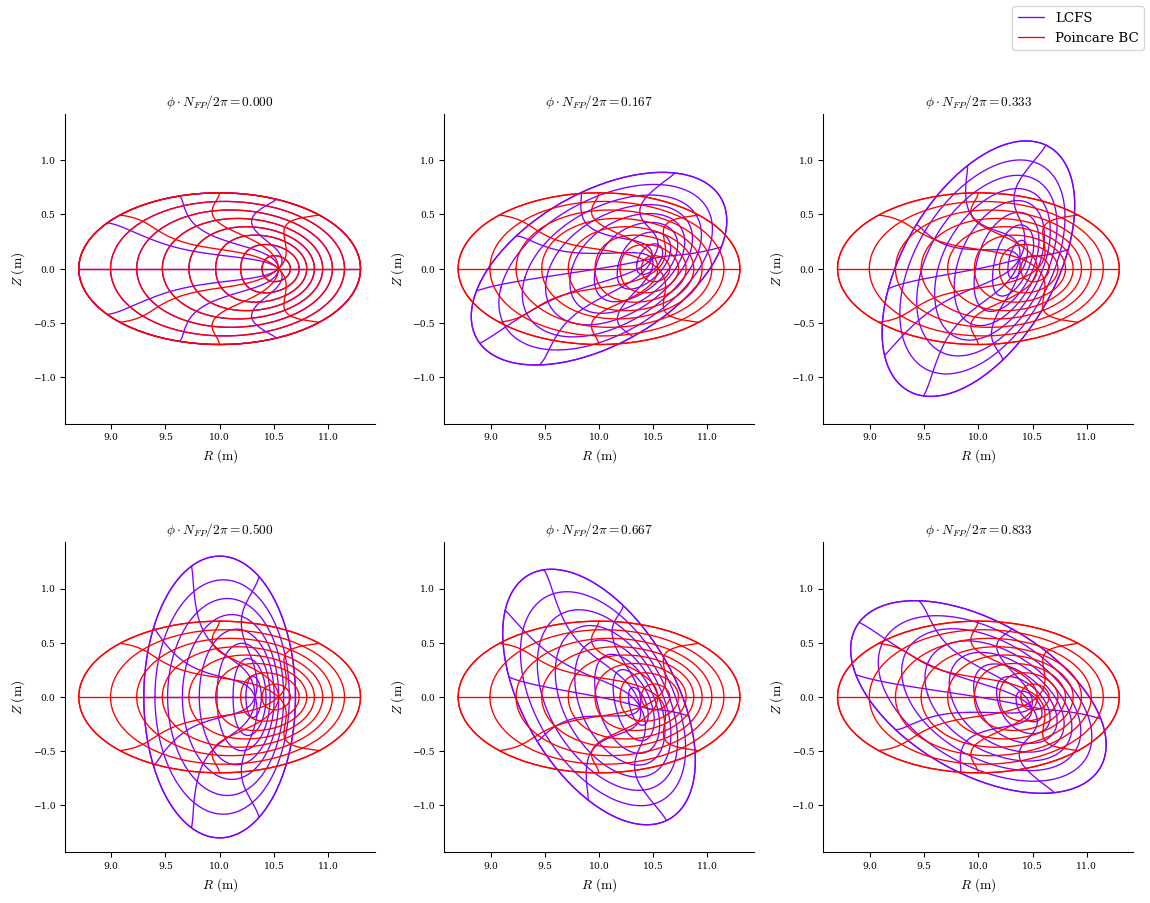

In [5]:
eq = get("HELIOTRON")
zeta = 0
eq_poin = eq.set_poincare_equilibrium(zeta=zeta)

eq_poin.change_resolution(eq_poin.L,eq_poin.M,eq.N) 
eq_poin.N_grid=eq.N_grid
constraints = get_fixed_boundary_constraints(eq=eq_poin)
objective = ObjectiveFunction(ForceBalance(eq_poin))
optimizer = Optimizer("lsq-exact")

eq_poin.solve(verbose=3, ftol=0, objective=objective, constraints=constraints, optimizer=optimizer,maxiter=20, xtol=0)
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS',f'Poincare BC']);

### Creating a new Poincare surface to fix 

We can also create a new surface object calle "PoincareSurface" to set our optimizzation problem as LCFS.